In [2]:
from sklearn.datasets import fetch_openml
import numpy as np

# Load MNIST dataset
mnist = fetch_openml('mnist_784', version=1)
X = np.array(mnist.data)  # Features (28x28 images flattened into 784-dimensional vectors)
y = np.array(mnist.target)  # Labels (digit class: 0–9)

print("Shape of X:", X.shape)  # (70000, 784)
print("Shape of y:", y.shape)  # (70000,)


Shape of X: (70000, 784)
Shape of y: (70000,)


In [3]:
# Normalize the pixel values
X = X / 255.0

In [4]:
from sklearn.decomposition import PCA

# Reduce to 2 principal components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

print("Shape of reduced data:", X_pca.shape)  # (70000, 2)


Shape of reduced data: (70000, 2)


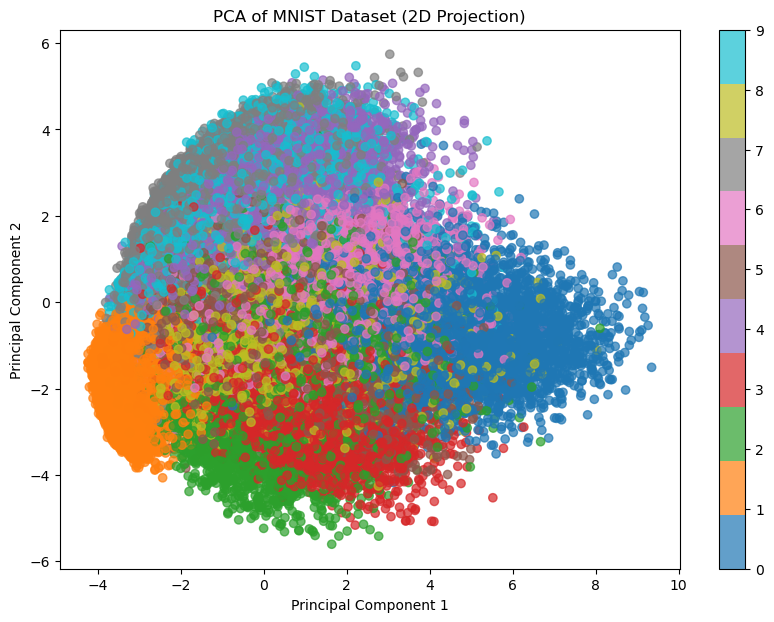

In [6]:
import matplotlib.pyplot as plt

# Create a scatter plot of the first two principal components
plt.figure(figsize=(10, 7))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y.astype(int), cmap='tab10', alpha=0.7)
plt.colorbar(scatter, ticks=range(10))
plt.title("PCA of MNIST Dataset (2D Projection)")
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.show()

In [7]:
from sklearn.decomposition import PCA
import numpy as np

# Fit PCA without limiting components
pca_full = PCA()
pca_full.fit(X)

# Cumulative explained variance
cumulative_variance = np.cumsum(pca_full.explained_variance_ratio_)

# Find the number of components for 80% variance
n_components_80 = np.argmax(cumulative_variance >= 0.8) + 1
print("Number of components to retain 80% variance:", n_components_80)


Number of components to retain 80% variance: 43


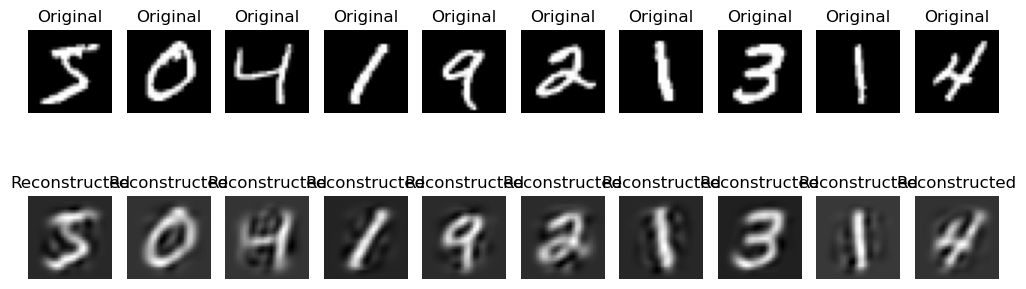

In [8]:
# Reduce to 50 components
pca_80 = PCA(n_components=n_components_80)
X_reduced = pca_80.fit_transform(X)

# Reconstruct images
X_reconstructed = pca_80.inverse_transform(X_reduced)

# Visualize the original and reconstructed images
def plot_images(original, reconstructed, n=5):
    plt.figure(figsize=(10, 4))
    for i in range(n):
        # Original
        plt.subplot(2, n, i + 1)
        plt.imshow(original[i].reshape(28, 28), cmap='gray')
        plt.title("Original")
        plt.axis('off')
        
        # Reconstructed
        plt.subplot(2, n, n + i + 1)
        plt.imshow(reconstructed[i].reshape(28, 28), cmap='gray')
        plt.title("Reconstructed")
        plt.axis('off')
        
    plt.tight_layout()
    plt.show()

plot_images(X, X_reconstructed, n=10)

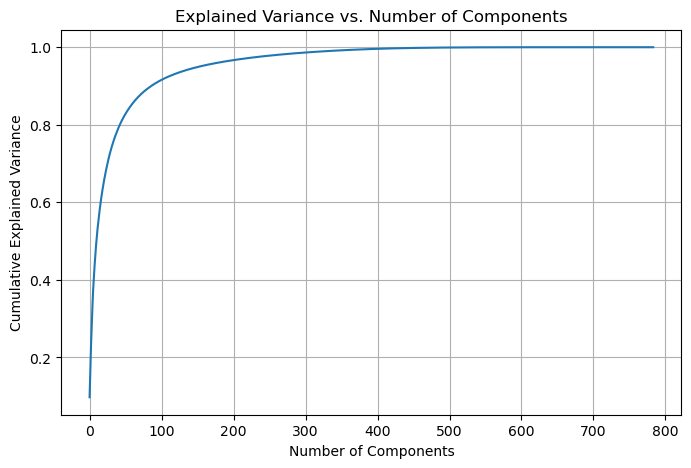

Number of components to explain 95% variance: 43


In [9]:
# Fit PCA without limiting components
pca_full = PCA().fit(X)

# Plot cumulative explained variance
plt.figure(figsize=(8, 5))
plt.plot(np.cumsum(pca_full.explained_variance_ratio_))
plt.xlabel("Number of Components")
plt.ylabel("Cumulative Explained Variance")
plt.title("Explained Variance vs. Number of Components")
plt.grid()
plt.show()

# Choose the number of components that explain ~95% of the variance
n_components_95 = np.argmax(np.cumsum(pca_full.explained_variance_ratio_) >= 0.8) + 1
print("Number of components to explain 95% variance:", n_components_95)


In [10]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split

# Split the PCA-reduced dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.2, random_state=42)

# Initialize the KNN classifier
knn = KNeighborsClassifier(n_neighbors=3)  # You can tune n_neighbors as needed

# Train the KNN model
knn.fit(X_train, y_train)

# Evaluate on the test set
test_accuracy = knn.score(X_test, y_test)
print(f"Test Accuracy of KNN Classifier: {test_accuracy * 100:.2f}%")


Test Accuracy of KNN Classifier: 97.68%


In [11]:
import joblib

# Save the PCA model and KNN model
joblib.dump(pca_80, "backend/pca_model.pkl")
joblib.dump(knn, "backend/knn_model.pkl")

# Load them back later
# loaded_pca = joblib.load("backend/pca_model.pkl")
# loaded_knn = joblib.load("backend/knn_model.pkl")


['backend/knn_model.pkl']

Predicted Label for New Image: 1
[[-2.96631125 -0.06710662  0.70766126 -1.92290977 -3.6131809  -0.29170323
  -1.96093756  0.28722555 -1.61280393 -0.33192699  0.42805268 -0.67817882
   0.02934743  0.34533259 -0.40568604  0.23746809 -0.59427291  0.61901544
   0.19173163  0.03924393 -0.02264465 -0.05465907  0.09486602 -0.13725105
   0.10535656 -0.10067396 -0.14311641  0.01910575  0.02183591  0.03084388
   0.06332555 -0.02406513  0.03594545  0.19906502 -0.02996703 -0.08525148
   0.01301991  0.00643758 -0.00950522 -0.04273335 -0.0895944   0.03017697
   0.12786602]]


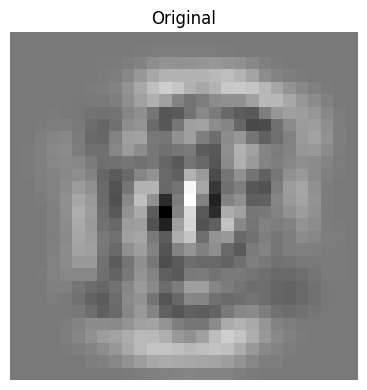

In [76]:
# Assuming the new image is a 28x28 pixel grayscale image
def preprocess_new_image(image: np.ndarray, pca_model: PCA):
    # Step 1: Resize the image to 28x28 pixels and flatten it (assuming the image is already in this shape)
    image_flat = image.reshape(1, -1)  # Flatten the image to a 1D vector
    
    # Step 2: Standardize the image (if needed, based on the scaling applied to training data)
    image_standardized = image_flat / 255.0 
    
    # Step 3: Apply PCA transformation
    image_pca = pca_model.transform(image_standardized)
    image_reconstructed = pca_model.inverse_transform(image_pca)
    
    return image_reconstructed

# Example of classifying a new image (replace 'new_image' with your actual image)
new_image = np.random.rand(28, 28)  # Replace with your new image (28x28)

image_flat = new_image.reshape(1, -1)  # Flatten the image to a 1D vector

image_standardized = image_flat / 255.0 

# image_pca = preprocess_new_image(new_image, pca_80)

# Step 3: Apply PCA transformation
image_pca = pca_80.transform(image_standardized)

# Step 4: Predict the class using the trained KNN model
predicted_label = knn.predict(image_pca)
print(f"Predicted Label for New Image: {predicted_label[0]}")

image_reconstructed = pca_80.inverse_transform(image_pca)

def plot_images(original ):
    plt.figure(figsize=(10, 4))
    # Original
    plt.imshow(original.reshape(28, 28), cmap='gray')
    plt.title("Original")
    plt.axis('off')
        
    plt.tight_layout()
    plt.show()

print(image_pca)
plot_images(image_reconstructed)
